In [ ]:
#Using Google Colab for tensorflow. Refer to Readme for understanding the Business problem.

In [8]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/CNNProjects/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Directly Downloading the data from Kaggle API Token

In [0]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pra133k","key":"670030f8a7016372edcf275d6737091d"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c plant-seedlings-classification -p /content/gdrive/My\ Drive/CNNProjects/kaggle

  0% 0.00/5.13k [00:00<?, ?B/s]
100% 5.13k/5.13k [00:00<00:00, 720kB/s]
100% 86.0M/86.0M [00:01<00:00, 49.3MB/s]

 99% 1.59G/1.60G [00:35<00:00, 39.2MB/s]
100% 1.60G/1.60G [00:35<00:00, 48.8MB/s]


In [0]:
import os
os.chdir('gdrive/My Drive/CNNProjects/kaggle')  #change dir
!mkdir train  #create a directory named train/
!mkdir test  #create a directory named test/
!unzip -q train.zip -d train/  #unzip data in train/
!unzip -q test.zip -d test/  #unzip data in test/
!unzip sample_submission.csv.zip
# !unzip train_labels.csv.zip

Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   


In [0]:
!mkdir test
!unzip -q test.zip -d test/

In [0]:
# Import necessary libraries

In [0]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import AveragePooling2D,Conv2D,Dense,Activation,BatchNormalization,Reshape,Dropout,Flatten,MaxPooling2D
from keras import optimizers
from keras.optimizers import Adam,Adagrad
from keras.callbacks import Callback,CallbackList
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from __future__ import absolute_import, division, print_function
import numpy as np
from sklearn.model_selection import train_test_split
import os
import glob
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from keras.utils import np_utils
from keras import optimizers
import time

In [0]:
# import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [0]:
seed = 7
np.random.seed(seed)

In [12]:
print(os.listdir('/content/gdrive/My Drive/CNNProjects/kaggle/train'))

['Common Chickweed', 'Maize', 'Common wheat', 'Scentless Mayweed', 'Loose Silky-bent', 'Fat Hen', 'Small-flowered Cranesbill', 'Cleavers', 'Black-grass', 'Sugar beet', 'Shepherds Purse', 'Charlock']


In [0]:
#Use of glob: The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order

In [0]:
path_toimages = '/content/gdrive/My Drive/CNNProjects/kaggle/train/*/*.png'
images = glob(path_toimages)

In [0]:
trainingset = []   #this will be used to append the images (.pngs)
traininglabels = []  # instead of assinging labels by ourselves I prefer to use label encoder then use the one hot encoding as we do in DL using to_categorical. We will choose the folders from the data frame later
scale = 70

num = len(images)
c = 1
# Reading images and resizing

for i in images:
  trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
  traininglabels.append(i.split('/'))  # Splitting for ensuring we get the classes in one column which I can use later to label encode.
  c = c+1
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

In [0]:
trainingset = trainingset/255

In [17]:
traininglabels.head(10)

,0,1,2,3,4,5,6,7,8
0,,content,gdrive,My Drive,CNNProjects,kaggle,train,Common Chickweed,7a597f825.png
1,,content,gdrive,My Drive,CNNProjects,kaggle,train,Common Chickweed,62351b320.png
2,,content,gdrive,My Drive,CNNProjects,kaggle,train,Common Chickweed,af005febb.png
3,,content,gdrive,My Drive,CNNProjects,kaggle,train,Common Chickweed,0f872f09e.png
4,,content,gdrive,My Drive,CNNProjects,kaggle,train,Common Chickweed,687fdd0f0.png
5,,content,gdrive,My Drive,CNNProjects,kaggle,train,Common Chickweed,c5ddfa4a2.png
6,,content,gdrive,My Drive,CNNProjects,kaggle,train,Common Chickweed,10c956c81.png
7,,content,gdrive,My Drive,CNNProjects,kaggle,train,Common Chickweed,feafa22cc.png
8,,content,gdrive,My Drive,CNNProjects,kaggle,train,Common Chickweed,19f62aae6.png
9,,content,gdrive,My Drive,CNNProjects,kaggle,train,Common Chickweed,518787d0b.png


In [18]:
# Label Encoder for the images and later turning them into categorical encoded labels
labels = LabelEncoder() #Label Encode the folders. 
labels.fit(traininglabels[7])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[7])

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


In [0]:
alllabels = np_utils.to_categorical(encodedlabels)

In [20]:
alllabels[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
classes = alllabels.shape[1]

In [22]:
print(str(classes))


12


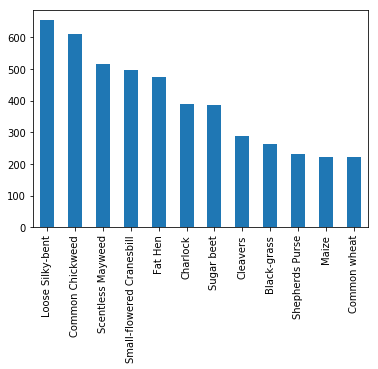

In [23]:
# Exploring the Data Set
traininglabels[7].value_counts().plot(kind='bar')


In [0]:
X_train,X_test,y_train,y_test = train_test_split(trainingset,alllabels,test_size = 0.30,random_state = seed)

In [25]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3325, 70, 70, 3), (1425, 70, 70, 3), (3325, 12), (1425, 12))

In [0]:
datagen = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1
                             ,horizontal_flip = True,
                             vertical_flip = True)
datagen.fit(X_train)

In [27]:
#model1
model = Sequential()
model.add(Conv2D(64,(5,5),input_shape= (70,70,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(5,5),activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.10))


model.add(Conv2D(128,(5,5),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.10))



model.add(Conv2D(256,(5,5),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.10))



model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.50))

model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.50))

model.add(Dense(12,activation='softmax'))


W0818 05:52:50.320695 140353949022080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 05:52:50.372330 140353949022080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 05:52:50.379256 140353949022080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 05:52:50.427698 140353949022080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0818 05:52:50.428849 1403539490

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       204928    
__________

In [28]:
optimizers = Adam(lr = 0.0001)
model.compile(optimizer = optimizers,loss ='categorical_crossentropy',metrics = ['accuracy'])

W0818 05:52:55.431952 140353949022080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
stop = EarlyStopping(monitor = 'val_loss',patience = 10, verbose = 1, mode = 'auto')

In [0]:
# filepath='/content/gdrive/My Drive/CNNProjects/kaggle/weights_plant_seedlings.best.hdf5'
# checkpoint = ModelCheckpoint(filepath,monitor='val_acc',verbose = 1, save_best_only=True,mode='max')


In [30]:
start = time.clock() 
model.fit_generator(datagen.flow(X_train, y_train,batch_size=32), validation_data=(X_test,y_test),epochs = 50,steps_per_epoch = X_train.shape[0],callbacks=[stop])
end = time.clock()

print("Train Time: {} ".format(end-start)) 

W0818 05:52:56.071374 140353949022080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
3325/3325 [==============================] - 327s 98ms/step - loss: 1.2672 - acc: 0.6104 - val_loss: 0.6031 - val_acc: 0.7825
Epoch 2/50
3325/3325 [==============================] - 321s 97ms/step - loss: 0.5143 - acc: 0.8248 - val_loss: 0.4964 - val_acc: 0.8042
Epoch 3/50
3325/3325 [==============================] - 322s 97ms/step - loss: 0.3255 - acc: 0.8859 - val_loss: 0.5647 - val_acc: 0.8007
Epoch 4/50
3325/3325 [==============================] - 321s 96ms/step - loss: 0.2311 - acc: 0.9169 - val_loss: 0.2752 - val_acc: 0.8898
Epoch 5/50
3325/3325 [==============================] - 322s 97ms/step - loss: 0.1813 - acc: 0.9343 - val_loss: 0.2462 - val_acc: 0.8982
Epoch 6/50
3325/3325 [==============================] - 322s 97ms/step - loss: 0.1446 - acc: 0.9469 - val_loss: 0.2707 - val_acc: 0.9053
Epoch 7/50
3325/3325 [==============================] - 322s 97ms/step - loss: 0.1208 - acc: 0.9568 - val_loss: 0.4610 - val_acc: 0.8744
Epoch 8/50
3325/3325 [===================

In [31]:
model.evaluate(X_test,y_test)

1425/1425 [==============================] - 1s 890us/step


[0.42512507635250424, 0.901754386048568]

In [0]:
# TestSet Images
path_toimages_test = '/content/gdrive/My Drive/CNNProjects/kaggle/test/test/*.png'
images_test = glob(path_toimages_test)

In [0]:
testset = []
test_submissions = []
scale = 70
c = 1
# Reading images and resizing

for i in images_test:
  test_submissions.append(i.split('/')[-1])
  testset.append(cv2.resize(cv2.imread(i),(scale,scale)))
  c = c+1
testset = np.asarray(testset)

In [0]:
testset = testset/255

In [0]:
predictions = model.predict(testset)
preds_sub = np.argmax(predictions,axis = 1)


In [36]:
predictions

array([[2.4478528e-09, 6.1297079e-10, 5.5218483e-09, ..., 5.4382077e-10,
        6.5823215e-08, 6.8189756e-09],
       [1.3108739e-05, 2.3382665e-04, 2.3960053e-04, ..., 1.1575881e-05,
        9.9648225e-01, 4.7643757e-06],
       [4.2177165e-01, 8.6221562e-06, 6.1673159e-06, ..., 1.9119554e-05,
        5.5062235e-05, 4.8450100e-05],
       ...,
       [4.8447102e-08, 9.9999726e-01, 5.4227371e-07, ..., 1.3776539e-08,
        2.1570118e-07, 8.6143544e-08],
       [1.6144299e-04, 5.5701131e-01, 9.5456962e-05, ..., 4.3882248e-01,
        8.9308502e-05, 2.6862426e-03],
       [3.3530089e-06, 2.7735086e-06, 8.3075975e-06, ..., 5.6960666e-06,
        1.0821843e-06, 1.4902803e-04]], dtype=float32)

In [0]:
predStr = labels.classes_[preds_sub]
result = {'file': test_submissions,'species':predStr}
df = pd.DataFrame(result)
df.to_csv('/content/gdrive/My Drive/CNNProjects/kaggle/Predictions_Seeds.csv',index = False)


***LeaderBoard Score on Kaggle-->91%***

### Insights:
- Used the VGG16 multiple layers to train but stopped at 256 Filters since post that it was running into '-' shapes.
- Implement Transfer Learning using vgg16 to verify if I can improve better then 91%. 
- Below code only provided 71%. Could not re run it again before submitting as Colab ot disconnected.
- Also Implemented ResNet which only provided 20% accuracy.

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input


In [5]:
num_classes = 12
base_models = VGG16(weights='imagenet',include_top = False,input_shape= (70,70,3))

W0818 08:24:25.740622 139865532934016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 08:24:25.792572 139865532934016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 08:24:25.801233 139865532934016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 08:24:25.847720 139865532934016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 1s 0us/step


W0818 08:24:27.274347 139865532934016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0818 08:24:27.275868 139865532934016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [8]:
# Finetune VGG16

from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_models, dropout, fc_layers, num_classes):
    for layer in base_models.layers:
        layer.trainable = False

    x = base_models.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_models.input, outputs=predictions)

    return finetune_model

FC_LAYERS = [256, 256]
dropout = 0.5

finetune_model = build_finetune_model(base_models, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=12)

W0818 08:25:31.443216 139865532934016 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
optimizers = Adam(lr = 0.0001)
finetune_model.compile(optimizer = optimizers,loss ='categorical_crossentropy',metrics = ['accuracy'])
stop = EarlyStopping(monitor = 'loss',patience = 10, verbose = 1, mode = 'auto')
# filepath='/content/gdrive/My Drive/CNNProjects/kaggle/weights.best.hdf5'
# checkpoint = ModelCheckpoint(filepath,monitor='val_acc',verbose = 1, save_best_only=True,mode='max')

W0818 08:26:24.099623 139865532934016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [10]:
finetune_model.fit_generator(datagen.flow(X_train, y_train,
                        batch_size=32), validation_data=(X_test,y_test),epochs = 50,steps_per_epoch = X_train.shape[0],callbacks=[stop])

NameError: ignored

In [0]:
finetune_model.evaluate(X_test,y_test)

Implemented VGGNet16 trained network using transfer learning and the concept by using VGG16 on all layers. Recieve the better accuracy 90% by training on all layers.

Transfer Learning using vgg16 had 71 % accuracy